In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [ ]:
# The size of our mini batches
batch_size = 16
# How many itterations of our dataset
num_epochs = 50

# Optimizer learning rate
learning_rate = 1e-4


data_set_root = "D:/p3 dataset/skin_cancer_segmented"

# The size of each patch in the sequence
# Our images are quite small so we'll use a smaller image patch size
patch_size = 16

In [ ]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
transform = transforms.Compose([transforms.RandomResizedCrop(64), transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1
# Note: We are normalizing with the dataset mean and std

In [ ]:
train_data = datasets.ImageFolder(data_set_root, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then
# everytime we randomly split our training and validation set we would get different splits!!!
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 9013
Number of validation examples: 1002


In [ ]:
# Create the training, Validation and Evaluation/Test Datasets
# It is best practice to separate your data into these three Datasets
# Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
# (It also depends on how much data you have)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)


In [ ]:
def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()

    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)

    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)

    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)

    return unfolded

In [ ]:
# Create a dataloader itterable object
dataiter = next(iter(train_loader))
# Sample from the itterable object
train_images, train_labels = dataiter
print(f"Image shape: {train_images.shape}")

Image shape: torch.Size([16, 3, 64, 64])


Sequence Length 16


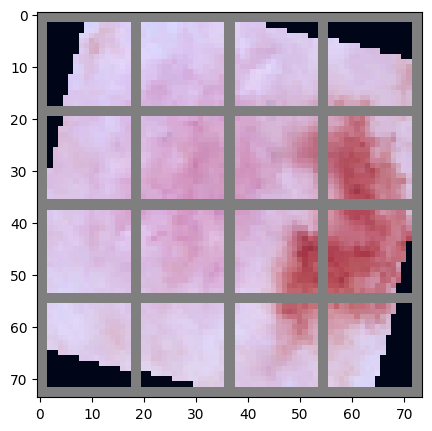

In [ ]:
# Extract patches from the test images using the defined function
patches = extract_patches(train_images, patch_size=patch_size)

patches_square = patches.reshape(train_images.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = train_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# Transformer block with self-attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=64, num_heads=4):
        # Initialize the parent nn.Module
        super(TransformerBlock, self).__init__()

        # Layer normalization to normalize the input data
        self.norm1 = nn.LayerNorm(hidden_size)

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads,
                                                    batch_first=True, dropout=0.1)

        # Another layer normalization
        self.norm2 = nn.LayerNorm(hidden_size)

        # Multi-layer perceptron (MLP) with a hidden layer and activation function
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )

    def forward(self, x):
        # Apply the first layer normalization
        norm_x = self.norm1(x)

        # Apply multi-head attention and add the input (residual connection)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x

        # Apply the second layer normalization
        norm_x = self.norm2(x)

        # Pass through the MLP and add the input (residual connection)
        x = self.mlp(norm_x) + x

        return x


class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size, num_layers, num_heads=8):
        # Call the __init__ function of the parent nn.Module class
        super(ViT, self).__init__()

        self.patch_size = patch_size

        # Fully connected layer to project input patches to the hidden size dimension
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)

        # Create a list of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        # Fully connected output layer to map to the number of classes (e.g., 10 for CIFAR-10)
        self.fc_out = nn.Linear(hidden_size, 7)

        # Parameter for the output token
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))

        # Positional embeddings to retain positional information of patches
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.001))

    def forward(self, image):
        bs = image.shape[0]

        # Extract patches from the image and flatten them
        patch_seq = extract_patches(image, patch_size=self.patch_size)

        # Project patches to the hidden size dimension
        patch_emb = self.fc_in(patch_seq)

        # Add positional embeddings to the patch embeddings
        patch_emb = patch_emb + self.pos_embedding

        # Concatenate the output token to the patch embeddings
        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        # Pass the embeddings through each Transformer block
        for block in self.blocks:
            embs = block(embs)

        # Use the embedding of the output token for classification
        return self.fc_out(embs[:, 0])

In [ ]:
# Create a dataloader itterable object
dataiter = next(iter(train_loader))
# Sample from the itterable object
train_images, train_labels = dataiter
print(f"Image shape: {train_images.shape}")

Image shape: torch.Size([16, 3, 64, 64])


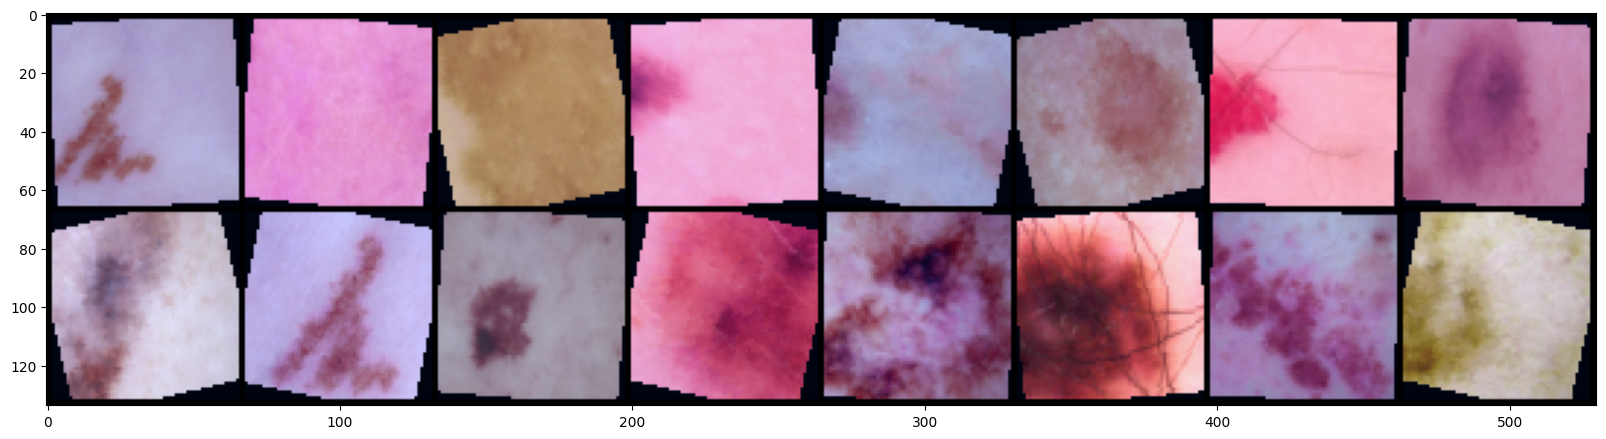

In [ ]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images (1 channel for MNIST)
model = ViT(image_size=train_images.shape[2],
            channels_in=train_images.shape[1],
            patch_size=patch_size,
            hidden_size=128,
            num_layers=8,
            num_heads=8).to(device)

# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

ViT(
  (fc_in): Linear(in_features=768, out_features=128, bias=True)
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=7, bias=True)
)


In [ ]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 1165447 (Approximately 1 Million) Parameters!


In [ ]:
# Pass image through network
out = model(train_images.to(device))
# Check output
out.shape

torch.Size([16, 7])

In [ ]:
# Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=num_epochs,
                                                    eta_min=0)
# Define a Cross Entropy Loss
loss_fun = nn.CrossEntropyLoss()

In [ ]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):

    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx = model(x.to(device))

        # Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))

        # Zero Gradents
        optimizer.zero_grad()
        # Backpropagate Gradents
        loss.backward()
        # Do a single optimization step
        optimizer.step()

        # Log the loss for plotting
        loss_logger.append(loss.item())

    # Return the avaerage loss and acc from the epoch as well as the logger array
    return model, optimizer, loss_logger

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

def evaluate(model, device, loader):
    epoch_acc = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            fx = model(x.to(device))
            preds = fx.argmax(1).cpu().numpy()
            labels = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

            epoch_acc += (preds == labels).sum().item()

    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    accuracy = epoch_acc / len(loader.dataset)
    return accuracy, precision, recall, f1

In [ ]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []
valid_acc = 0
train_acc = 0

# Metrics loggers
validation_precision_logger = []
validation_recall_logger = []
validation_f1_logger = []

training_precision_logger = []
training_recall_logger = []
training_f1_logger = []

pbar = trange(0, num_epochs, leave=False, desc="Epoch")
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    model, optimizer, training_loss_logger = train(model=model,
                                                   optimizer=optimizer,
                                                   loader=train_loader,
                                                   device=device,
                                                   loss_fun=loss_fun,
                                                   loss_logger=training_loss_logger)

    train_acc, train_precision, train_recall, train_f1 = evaluate(model=model, device=device, loader=train_loader)
    valid_acc, valid_precision, valid_recall, valid_f1 = evaluate(model=model, device=device, loader=valid_loader)

    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

    # Log precision, recall, and F1 score
    training_precision_logger.append(train_precision)
    training_recall_logger.append(train_recall)
    training_f1_logger.append(train_f1)

    validation_precision_logger.append(valid_precision)
    validation_recall_logger.append(valid_recall)
    validation_f1_logger.append(valid_f1)

    # Reduce learning rate
    lr_scheduler.step()

pbar.set_postfix_str(f'Accuracy: Train {train_acc * 100:.2f}%, Val {valid_acc * 100:.2f}%, F1: Train {train_f1:.2f}, Val {valid_f1:.2f}')
print("Training Complete")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/564 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Training Complete


C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


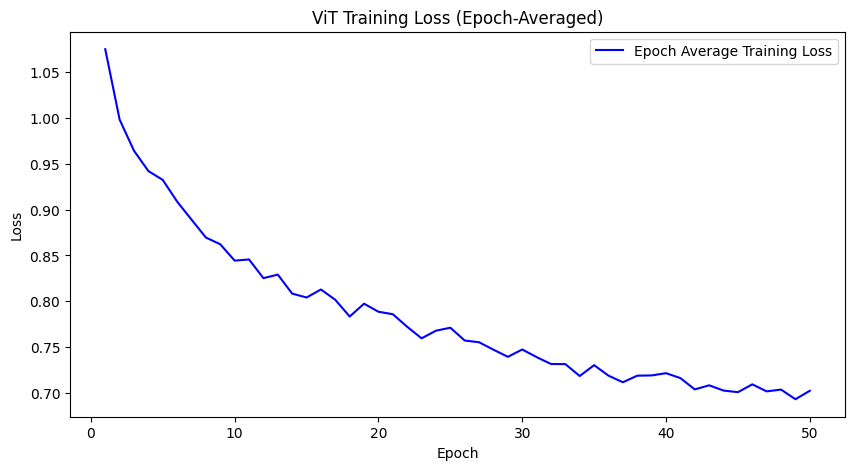

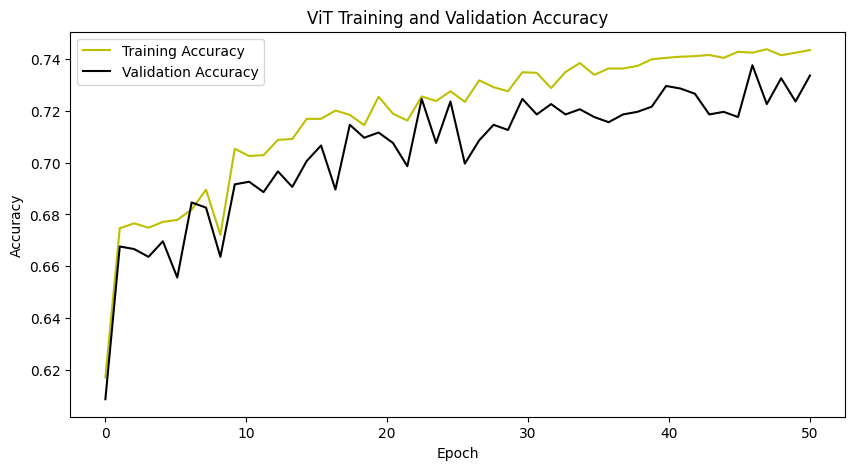

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate epoch-level average losses
num_batches_per_epoch = len(training_loss_logger) // num_epochs
epoch_avg_loss = [
    np.mean(training_loss_logger[i * num_batches_per_epoch:(i + 1) * num_batches_per_epoch])
    for i in range(num_epochs)
]

# Plot epoch-level averaged loss
plt.figure(figsize=(10, 5))
epoch_x = np.arange(1, num_epochs + 1)  # 1 to num_epochs
plt.plot(epoch_x, epoch_avg_loss, label="Epoch Average Training Loss", color="b")
plt.title("ViT Training Loss (Epoch-Averaged)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(train_x, training_acc_logger, c="y", label="Training Accuracy")
plt.plot(valid_x, validation_acc_logger, c="k", label="Validation Accuracy")
plt.title("ViT Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


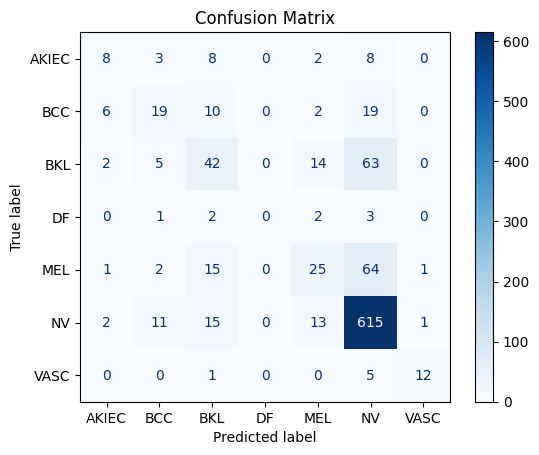

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, device, class_names=None):
    # Collect all predictions and true labels
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            outputs = model(x)
            preds = outputs.argmax(1).cpu().numpy()
            labels = y.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, valid_loader, device, class_names=['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])


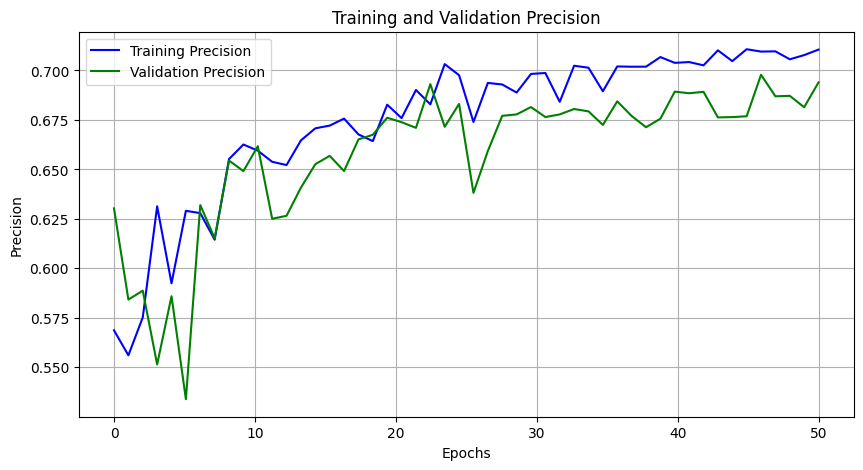

In [ ]:

plt.figure(figsize=(10, 5))
train_x = np.linspace(0, num_epochs, len(training_precision_logger))
valid_x = np.linspace(0, num_epochs, len(validation_precision_logger))

plt.plot(train_x, training_precision_logger, label='Training Precision', color='b')
plt.plot(valid_x, validation_precision_logger, label='Validation Precision', color='g')

plt.title("Training and Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()


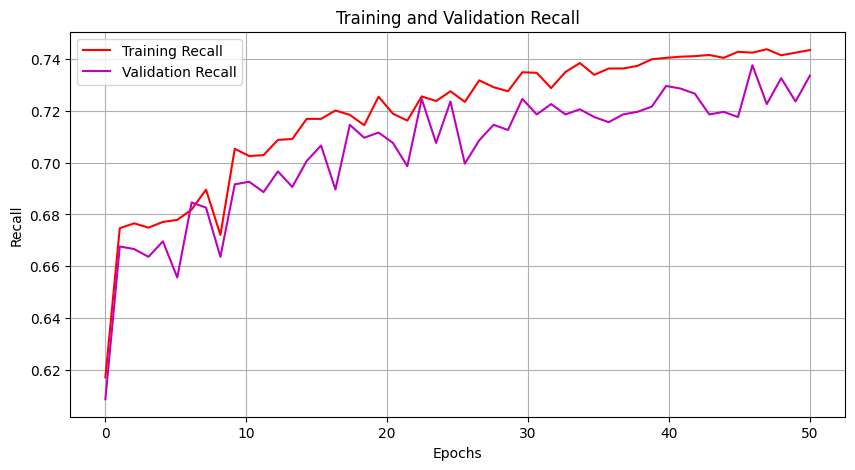

In [ ]:
plt.figure(figsize=(10, 5))
train_x = np.linspace(0, num_epochs, len(training_recall_logger))
valid_x = np.linspace(0, num_epochs, len(validation_recall_logger))

plt.plot(train_x, training_recall_logger, label='Training Recall', color='r')
plt.plot(valid_x, validation_recall_logger, label='Validation Recall', color='m')

plt.title("Training and Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()
plt.show()


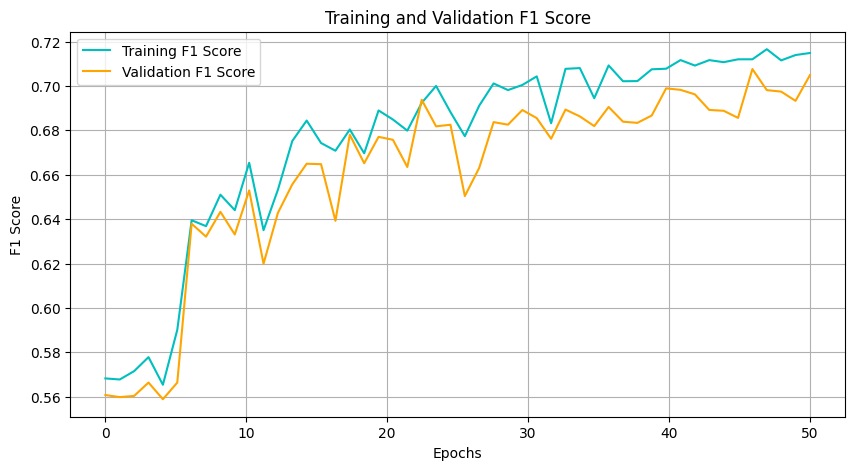

In [ ]:
plt.figure(figsize=(10, 5))
train_x = np.linspace(0, num_epochs, len(training_f1_logger))
valid_x = np.linspace(0, num_epochs, len(validation_f1_logger))

plt.plot(train_x, training_f1_logger, label='Training F1 Score', color='c')
plt.plot(valid_x, validation_f1_logger, label='Validation F1 Score', color='orange')

plt.title("Training and Validation F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print("Training Accuracy: %.2f%%" % (train_acc * 100))
print("Validation Accuracy: %.2f%%" % (valid_acc * 100))
print(f'Accuracy: Train {train_acc * 100:.2f}%, Val {valid_acc * 100:.2f}%, F1: Train {train_f1:.2f}, Val {valid_f1:.2f}')
print(f'Train Precision {training_precision_logger[-1]:.2f}, Valid Precision {validation_precision_logger[-1]:.2f}')
print(f'Train Recall {training_recall_logger[-1]:.2f}, Valid recall {validation_recall_logger[-1]:.2f}')
print(f'Train loss {training_loss_logger[-1]:.2f}')

Training Accuracy: 74.34%
Validation Accuracy: 73.35%
Accuracy: Train 74.34%, Val 73.35%, F1: Train 0.71, Val 0.70
Train Precision 0.71, Valid Precision 0.69
Train Recall 0.74, Valid recall 0.73
Train loss 0.55


In [ ]:
def save_model(model, optimizer, epoch, path="D:/20201033/final/VIT/VIT_gradcam_FINAL.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Model saved to {path}")

In [ ]:
# Save the trained model
model_save_path = 'D:/20201033/final/VIT/VIT_gradcam_FINAL.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to D:/20201033/final/VIT/VIT_gradcam_FINAL.pth


In [ ]:
import torch

# Load the model weights safely
state_dict = torch.load(model_save_path, weights_only=True)
model.load_state_dict(torch.load('D:/20201033/final/VIT/VIT_gradcam_FINAL.pth'))
# Load the state dict into the model

print(f"Model weights loaded from {model_save_path}")


TypeError: Expected state_dict to be dict-like, got <class '__main__.ViT'>.

In [ ]:
torch.save(model, 'D:/20201033/final/VIT/VIT_gradcam_FINAL.pth')

In [ ]:
# Extract the positional embeddings
pos_embs = model.pos_embedding.detach().cpu()
# Calculate the cosine similarity between every positional embedding
dist = F.cosine_similarity(pos_embs, pos_embs.reshape(64, 1, 128), dim=-1).numpy()
n_rows_cols = 32//patch_size
fig, axes = plt.subplots(n_rows_cols, n_rows_cols, figsize=(5, 5))
for i in range(n_rows_cols):
    for j in range(n_rows_cols):
        # Generate a sample image
        img = dist[j + i * n_rows_cols].reshape(n_rows_cols, n_rows_cols)

        # Display the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Hide the axes

# Adjust layout and show the grid
plt.tight_layout()
plt.show()

RuntimeError: shape '[64, 1, 128]' is invalid for input of size 2048

# GRAD CAM

In [ ]:
# do it in terminal
!pip install grad-cam

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


vit gradcam

Predicted class: 5


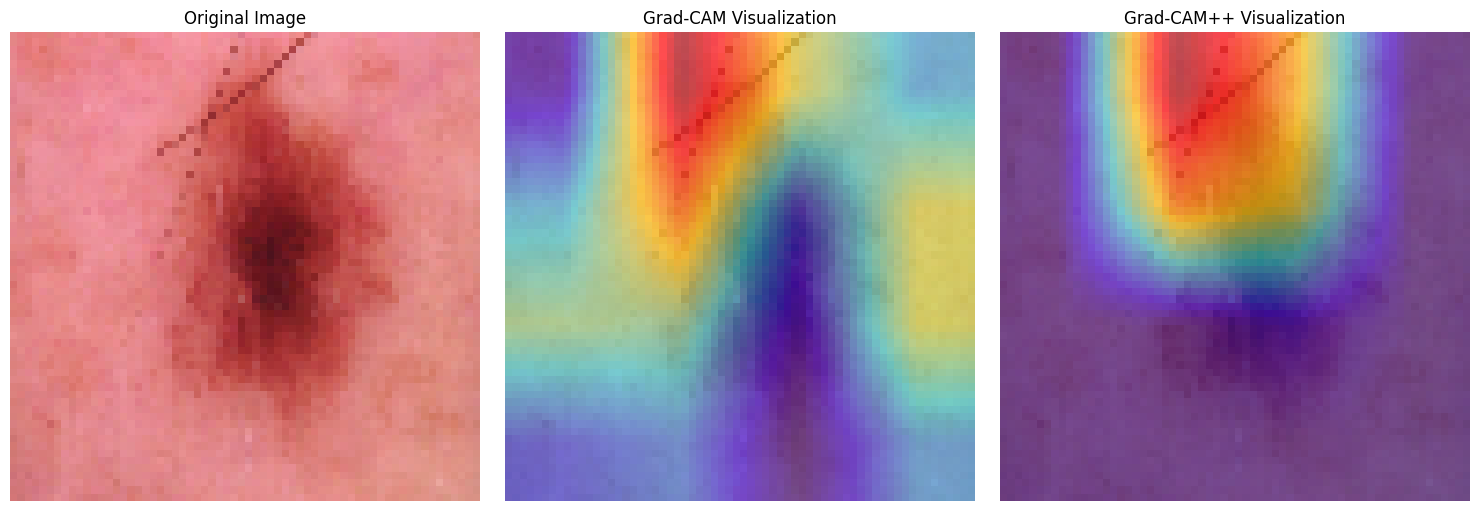

In [ ]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import functional as F

# height = width = image_size/patch_size = 64/16
# Adjust reshape function for your ViT
def reshape_transform(tensor, height=4, width=4):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Define target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Adjust based on your model architecture
targets = [ClassifierOutputTarget(5)]

# Load and preprocess an input image
# Replace with a valid path to your image or upload an image in Colab
image_path = 'D:/p3 dataset/skin_cancer_segmented/NV/ISIC_0024306.jpg'  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (64, 64))  # Resize to your model's expected input size
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

model.eval()
pred = model(input_tensor)
print("Predicted class:", torch.argmax(pred).item())

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# Initialize Grad-CAM++
cam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets = targets)
grayscale_cam = grayscale_cam[0, :]
# Generate Grad-CAM++
grayscale_cam_plusplus = cam_plusplus(input_tensor=input_tensor, targets=targets)
grayscale_cam_plusplus = grayscale_cam_plusplus[0,:]

# Overlay CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# Overlay Grad-CAM++ on the image
visualization_plusplus = show_cam_on_image(rgb_img, grayscale_cam_plusplus, use_rgb=True)


# Plot original image, Grad-CAM, and Grad-CAM++ visualizations
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')

# Grad-CAM++ visualization
plt.subplot(1, 3, 3)
plt.imshow(visualization_plusplus)
plt.title("Grad-CAM++ Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()

aresnn gradcam

Predicted class: 5


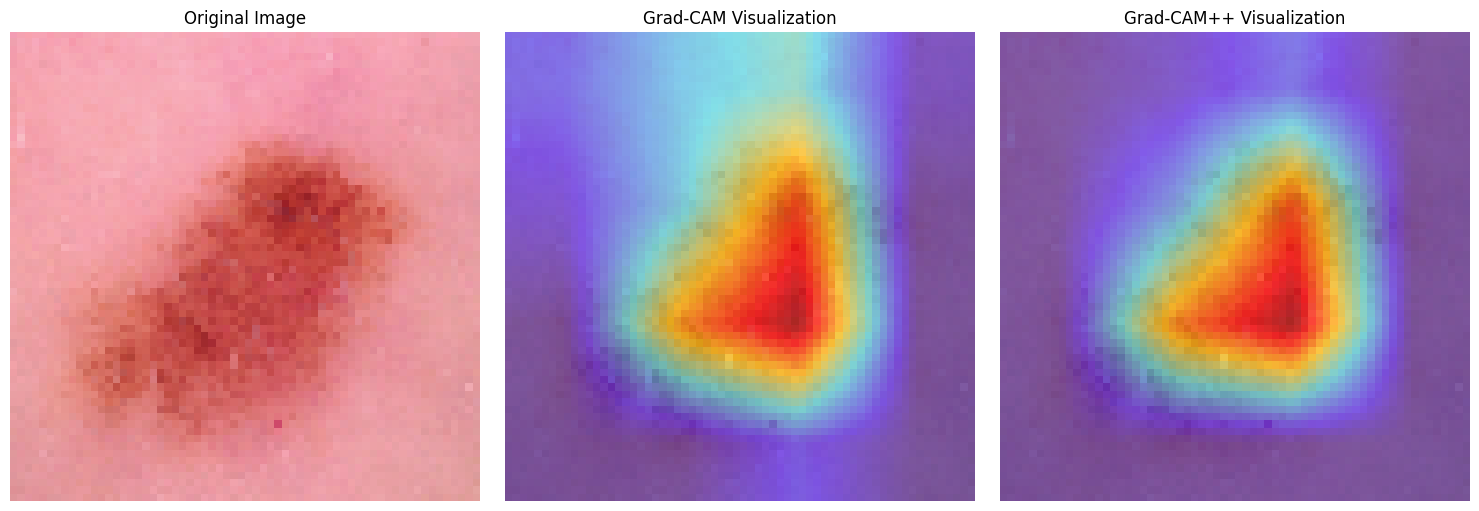

In [ ]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import functional as F

# height = width = image_size/patch_size = 64/16
# Adjust reshape function for your ViT
def reshape_transform(tensor, height=4, width=4):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Define target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Adjust based on your model architecture
targets = [ClassifierOutputTarget(5)]

# Load and preprocess an input image
# Replace with a valid path to your image or upload an image in Colab
image_path = 'D:/p3 dataset/skin_cancer_segmented/NV/ISIC_0024311.jpg'  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (64, 64))  # Resize to your model's expected input size
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

model.eval()
pred = model(input_tensor)
print("Predicted class:", torch.argmax(pred).item())

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# Initialize Grad-CAM++
cam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets = targets)
grayscale_cam = grayscale_cam[0, :]
# Generate Grad-CAM++
grayscale_cam_plusplus = cam_plusplus(input_tensor=input_tensor, targets=targets)
grayscale_cam_plusplus = grayscale_cam_plusplus[0,:]

# Overlay CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# Overlay Grad-CAM++ on the image
visualization_plusplus = show_cam_on_image(rgb_img, grayscale_cam_plusplus, use_rgb=True)


# Plot original image, Grad-CAM, and Grad-CAM++ visualizations
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')

# Grad-CAM++ visualization
plt.subplot(1, 3, 3)
plt.imshow(visualization_plusplus)
plt.title("Grad-CAM++ Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()

resnet50 gradcam

Predicted class: 5


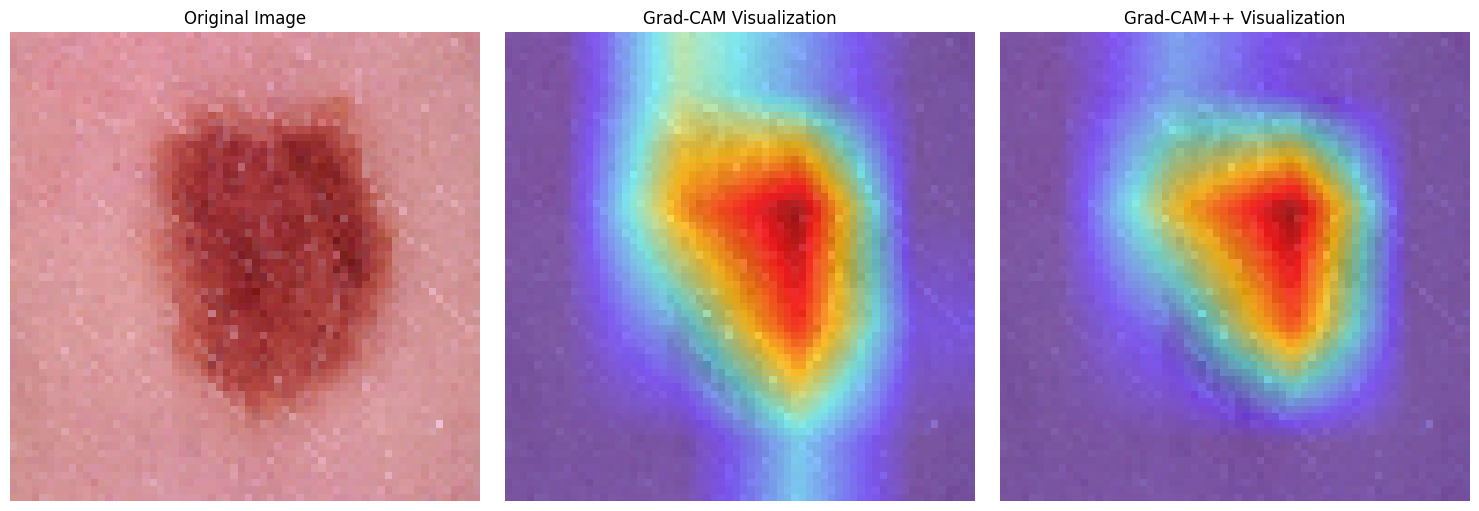

In [ ]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import functional as F

# height = width = image_size/patch_size = 64/16
# Adjust reshape function for your ViT
def reshape_transform(tensor, height=4, width=4):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Define target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Adjust based on your model architecture
targets = [ClassifierOutputTarget(5)]

# Load and preprocess an input image
# Replace with a valid path to your image or upload an image in Colab
image_path = 'D:/p3 dataset/skin_cancer_segmented/NV/ISIC_0024327.jpg'  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (64, 64))  # Resize to your model's expected input size
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

model.eval()
pred = model(input_tensor)
print("Predicted class:", torch.argmax(pred).item())

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# Initialize Grad-CAM++
cam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets = targets)
grayscale_cam = grayscale_cam[0, :]
# Generate Grad-CAM++
grayscale_cam_plusplus = cam_plusplus(input_tensor=input_tensor, targets=targets)
grayscale_cam_plusplus = grayscale_cam_plusplus[0,:]

# Overlay CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# Overlay Grad-CAM++ on the image
visualization_plusplus = show_cam_on_image(rgb_img, grayscale_cam_plusplus, use_rgb=True)


# Plot original image, Grad-CAM, and Grad-CAM++ visualizations
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')

# Grad-CAM++ visualization
plt.subplot(1, 3, 3)
plt.imshow(visualization_plusplus)
plt.title("Grad-CAM++ Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()

vgg16 gradcam

Predicted class: 5


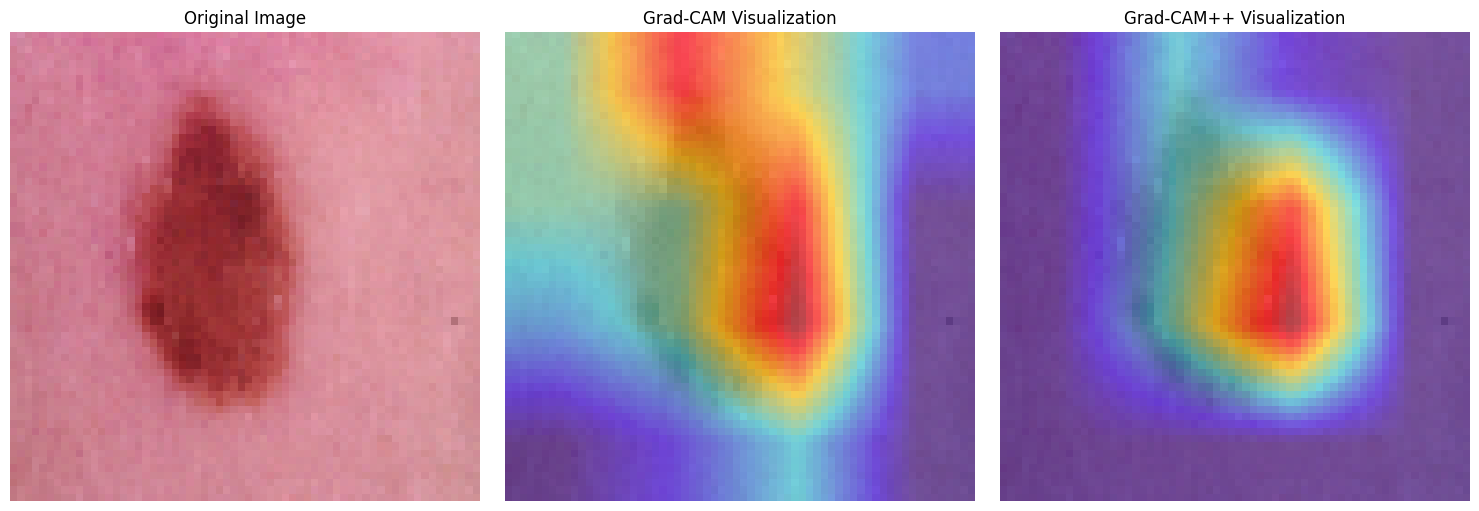

In [ ]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import functional as F

# height = width = image_size/patch_size = 64/16
# Adjust reshape function for your ViT
def reshape_transform(tensor, height=4, width=4):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Define target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Adjust based on your model architecture
targets = [ClassifierOutputTarget(5)]

# Load and preprocess an input image
# Replace with a valid path to your image or upload an image in Colab
image_path = "D:/p3 dataset/skin_cancer_segmented/NV/ISIC_0024341.jpg"  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (64, 64))  # Resize to your model's expected input size
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

model.eval()
pred = model(input_tensor)
print("Predicted class:", torch.argmax(pred).item())

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# Initialize Grad-CAM++
cam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets = targets)
grayscale_cam = grayscale_cam[0, :]
# Generate Grad-CAM++
grayscale_cam_plusplus = cam_plusplus(input_tensor=input_tensor, targets=targets)
grayscale_cam_plusplus = grayscale_cam_plusplus[0,:]

# Overlay CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# Overlay Grad-CAM++ on the image
visualization_plusplus = show_cam_on_image(rgb_img, grayscale_cam_plusplus, use_rgb=True)


# Plot original image, Grad-CAM, and Grad-CAM++ visualizations
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')

# Grad-CAM++ visualization
plt.subplot(1, 3, 3)
plt.imshow(visualization_plusplus)
plt.title("Grad-CAM++ Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()

swin gradcam

Predicted class: 5


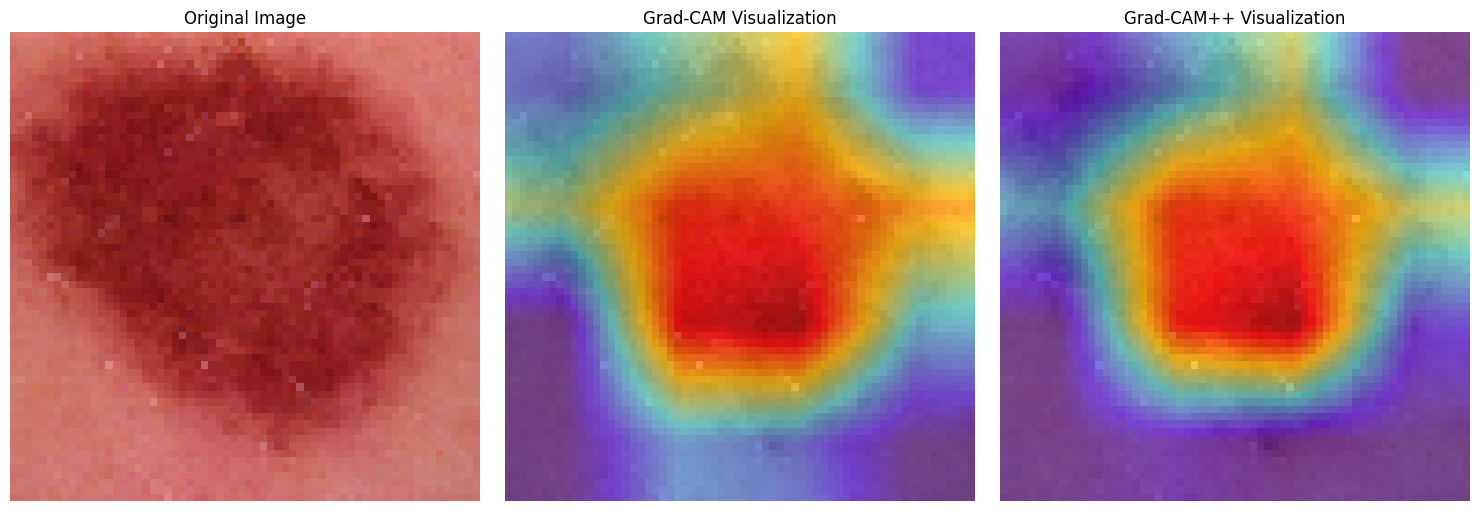

In [ ]:
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms import functional as F

# height = width = image_size/patch_size = 64/16
# Adjust reshape function for your ViT
def reshape_transform(tensor, height=4, width=4):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Define target layers for Grad-CAM
target_layers = [model.blocks[-1].norm1]  # Adjust based on your model architecture
targets = [ClassifierOutputTarget(5)]

# Load and preprocess an input image
# Replace with a valid path to your image or upload an image in Colab
image_path = "D:/p3 dataset/skin_cancer_segmented/NV/ISIC_0024415.jpg"  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (64, 64))  # Resize to your model's expected input size
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

model.eval()
pred = model(input_tensor)
print("Predicted class:", torch.argmax(pred).item())

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# Initialize Grad-CAM++
cam_plusplus = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets = targets)
grayscale_cam = grayscale_cam[0, :]
# Generate Grad-CAM++
grayscale_cam_plusplus = cam_plusplus(input_tensor=input_tensor, targets=targets)
grayscale_cam_plusplus = grayscale_cam_plusplus[0,:]

# Overlay CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
# Overlay Grad-CAM++ on the image
visualization_plusplus = show_cam_on_image(rgb_img, grayscale_cam_plusplus, use_rgb=True)


# Plot original image, Grad-CAM, and Grad-CAM++ visualizations
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM Visualization")
plt.axis('off')

# Grad-CAM++ visualization
plt.subplot(1, 3, 3)
plt.imshow(visualization_plusplus)
plt.title("Grad-CAM++ Visualization")
plt.axis('off')

plt.tight_layout()
plt.show()